##### Importing Libraries

In [1]:
import gmsh 
using GR 
using LinearAlgebra
using Plots
using LaTeXStrings
# using Cubature

##### Creating a Mesh with 2D Triangular Elements

In [13]:
# Unit Square Geometry Definition

# Initialize Gmsh
gmsh.initialize()

# Set Gmsh Options for Terminal Output
gmsh.option.setNumber("General.Terminal", 1)

# Add a Model Named "Square"
gmsh.model.add("square")

# Set Mesh Density Parameter
lc = 0.05

# Define Four Corner Points of the Square with (x, y, z) Coordinates
gmsh.model.geo.addPoint(0, 0, 0, lc, 1)
gmsh.model.geo.addPoint(1, 0, 0, lc, 2)
gmsh.model.geo.addPoint(1, 1, 0, lc, 3)
gmsh.model.geo.addPoint(0, 1, 0, lc, 4)

# Define Four Edges by Connecting Points Pairwise
gmsh.model.geo.addLine(1, 2, 1)
gmsh.model.geo.addLine(2, 3, 2)
gmsh.model.geo.addLine(3, 4, 3)
gmsh.model.geo.addLine(4, 1, 4)

# Define a Curved Loop by Connecting the Four Edge Labels
gmsh.model.geo.addCurveLoop([1, 2, 3, 4], 1)

# Define a Surface Enclosed by the Curved Loop
gmsh.model.geo.addPlaneSurface([1], 1)

# Label the Surface for Identification
gmsh.model.setPhysicalName(2, 1, "My surface")

# Synchronize the Geometric Model with the Mesh Module
gmsh.model.geo.synchronize()

# Configuration for 2nd Order Elements
gmsh.option.setNumber("Mesh.ElementOrder", 2)
gmsh.option.setNumber("Mesh.SecondOrderLinear", 1) # I don't know what this line does

# Generate Two-Dimensional Mesh
gmsh.model.mesh.generate(2)

# Write Mesh to File (if desired)
gmsh.write("square.msh")

# Visualize Mesh in Gmsh's GUI (if desired)
gmsh.fltk.run()

# Finalize Gmsh to Clean Up Resources
gmsh.finalize()

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 50%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0s, CPU 0s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0345731s, CPU 0.015625s)
Info    : Meshing order 2 (curvilinear off)...
Info    : [  0%] Meshing curve 1 order 2
Info    : [ 20%] Meshing curve 2 order 2
Info    : [ 40%] Meshing curve 3 order 2
Info    : [ 60%] Meshing curve 4 order 2
Info    : [ 80%] Meshing surface 1 order 2
Info    : Done meshing order 2 (Wall 0.00475812s, CPU 0.015625s)
Info    : 1969 nodes 1028 elements
Info    : Writing 'square.msh'...
Info    : Done writing 'square.msh'
-------------------------------------------------------
Version       : 4.11.1
License       : GNU General Public License
Build OS      : Windows64-sdk
Build date    : 20221221
Build host    : gmsh.info
Build op

##### Code to perform 2D-FEM using 2nd order triangular elements and Gaussian quadrature for numerical integration.

Info    : Reading 'square.msh'...
Info    : 9 entities
Info    : 1969 nodes
Info    : 1028 elements
Info    : Done reading 'square.msh'


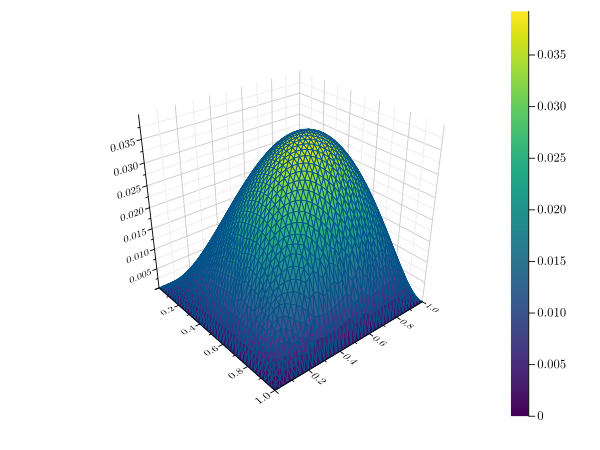

In [21]:
gmsh.initialize()

#..2/6: Read mesh from file
gmsh.open("square.msh")

#..2/12 Get and sort the mesh nodes
#..Observe that although the mesh is two-dimensional,
#..the z-coordinate that is equal to zero is stored as well.
#..Observe that the coordinates are stored contiguously for computational
#..efficiency
node_ids, node_coord, _ = gmsh.model.mesh.getNodes()
nnodes = length(node_ids)
#..sort the node coordinates by ID, such that Node one sits at row 1
tosort = [node_ids node_coord[1:3:end] node_coord[2:3:end]];
sorted = sortslices(tosort , dims = 1);
node_ids = sorted[:,1]
xnode = sorted[:,2]
ynode = sorted[:,3]

#..3/12 Plotting the mesh
#..for later: print mesh as VTK file and view using ParaView
#..(as documented under VTK.jl and as for instance GridApp.jl does)
z = ones(length(xnode))
# display(trisurf(xnode,ynode,z))

#..3/6: perform loop over the 1D elemements and construct I_bnd  
element_types, element_ids, element_connectivity = gmsh.model.mesh.getElements(2) ###TRY TO UNDERSTAND THIS WHY 1 OR 2
nelements = length(element_ids[1])

#..4/6: initialize vector of boundary indices (to be edited to avoid allocations withoi)
bnd_node_ids = Vector{Int64}([])

#..7/12 initialize global matrix A and global vector f
#..observe that for simplicity we use dense matrix here
A = zeros(nnodes,nnodes)
f = zeros(nnodes,1)

#..5/6: retrieve number of triangular elements on the 2D surface and their connectivity
for element_id in 1:nelements

    #....retrieve global numbering of the local nodes of the current element
    node1_id = element_connectivity[1][6*(element_id-1)+1]
    node2_id = element_connectivity[1][6*(element_id-1)+2]
    node3_id = element_connectivity[1][6*(element_id-1)+3]
    node4_id = element_connectivity[1][6*(element_id-1)+4]
    node5_id = element_connectivity[1][6*(element_id-1)+5]
    node6_id = element_connectivity[1][6*(element_id-1)+6]
    xnode1 = xnode[node1_id]; xnode2 = xnode[node2_id]; xnode3 = xnode[node3_id];
    xnode4 = xnode[node4_id]; xnode5 = xnode[node5_id]; xnode6 = xnode[node6_id];
    ynode1 = ynode[node1_id]; ynode2 = ynode[node2_id]; ynode3 = ynode[node3_id];
    ynode4 = ynode[node4_id]; ynode5 = ynode[node5_id]; ynode6 = ynode[node6_id];

    union!(bnd_node_ids,node1_id, node2_id, node3_id, node4_id, node5_id, node6_id) #I don't know what this line is for

    Emat = [[xnode1^2;xnode2^2;xnode3^2;xnode4^2;xnode5^2;xnode6^2] [ynode1^2;
    ynode2^2;ynode3^2;ynode4^2;ynode5^2;ynode6^2] [xnode1*ynode1;
    xnode2*ynode2;xnode3*ynode3;xnode4*ynode4;xnode5*ynode5;xnode6*ynode6] [xnode1;
    xnode2;xnode3;xnode4;xnode5;xnode6] [ynode1;
    ynode2;ynode3;ynode4;ynode5;ynode6] [1;1;1;1;1;1]]\UniformScaling(1.);
    
    a1 = Emat[1,1]; a2 = Emat[1,2]; a3 = Emat[1,3]; a4 = Emat[1,4]; a5 = Emat[1,5]; a6 = Emat[1,6]; #These 6 lines are redundant
    b1 = Emat[2,1]; b2 = Emat[2,2]; b3 = Emat[2,3]; b4 = Emat[2,4]; b5 = Emat[2,5]; b6 = Emat[2,6];
    c1 = Emat[3,1]; c2 = Emat[3,2]; c3 = Emat[3,3]; c4 = Emat[3,4]; c5 = Emat[3,5]; c6 = Emat[3,6];
    d1 = Emat[4,1]; d2 = Emat[4,2]; d3 = Emat[4,3]; d4 = Emat[4,4]; d5 = Emat[4,5]; d6 = Emat[4,6];
    e1 = Emat[5,1]; e2 = Emat[5,2]; e3 = Emat[5,3]; e4 = Emat[5,4]; e5 = Emat[5,5]; e6 = Emat[5,6];
    f1 = Emat[6,1]; f2 = Emat[6,2]; f3 = Emat[6,3]; f4 = Emat[6,4]; f5 = Emat[6,5]; f6 = Emat[6,6];

    a = [a1, a2, a3, a4, a5, a6];
    b = [b1, b2, b3, b4, b5, b6];
    c = [c1, c2, c3, c4, c5, c6];
    d = [d1, d2, d3, d4, d5, d6];
    e = [e1, e2, e3, e4, e5, e6];
    ff = [f1, f2, f3, f4, f5, f6];
    xn = [xnode1, xnode2, xnode3, xnode4, xnode5, xnode6];
    yn = [ynode1, ynode2, ynode3, ynode4, ynode5, ynode6];

    xi_gaussian = [2/3, 1/6, 1/6];
    eta_gaussian = [1/6, 2/3, 1/6];
    weight_gaussian = [1/3, 1/3, 1/3];

    function calculate_tranformation_coordinates(xi, eta, xn_1, xn_2, xn_3, yn_1, yn_2, yn_3)
        x = xn_1 + (xn_2 - xn_1)*xi + (xn_3 - xn_1)*eta
        y = yn_1 + (yn_2 - yn_1)*xi + (yn_3 - yn_1)*eta
        return x, y
    end

    jacobian_transformation = (xn[2] - xn[1])*(yn[3] - yn[1]) - (yn[2] - yn[1])*(xn[3] - xn[1])
    x_quad1, y_quad1 = calculate_tranformation_coordinates(xi_gaussian[1], eta_gaussian[1], xn[1], xn[2], xn[3], yn[1], yn[2], yn[3]);
    x_quad2, y_quad2 = calculate_tranformation_coordinates(xi_gaussian[2], eta_gaussian[2], xn[1], xn[2], xn[3], yn[1], yn[2], yn[3]);
    x_quad3, y_quad3 = calculate_tranformation_coordinates(xi_gaussian[3], eta_gaussian[3], xn[1], xn[2], xn[3], yn[1], yn[2], yn[3]);

    function calculate_function_value_Aloc(x, y, a_i, c_i, d_i, b_i, e_i, a_j, c_j, d_j, b_j, e_j)
        term1 = (2*a_i*x + c_i*y + d_i) * (2*a_j*x + c_j*y + d_j)
        term2 = (2*b_i*y + c_i*x + e_i) * (2*b_j*y + c_j*x + e_j)
    return term1 + term2
    end

    n = 6  # The size of your matrix
    Aloc = zeros(Float64, n, n)  # Initialize an empty nxn matrix
    for i in 1:n
        for j in 1:n
            function_value_point1 = calculate_function_value_Aloc(x_quad1, y_quad1, a[i], c[i], d[i], b[i], e[i], a[j], c[j], d[j], b[j], e[j]);
            function_value_point2 = calculate_function_value_Aloc(x_quad2, y_quad2, a[i], c[i], d[i], b[i], e[i], a[j], c[j], d[j], b[j], e[j]);
            function_value_point3 = calculate_function_value_Aloc(x_quad3, y_quad3, a[i], c[i], d[i], b[i], e[i], a[j], c[j], d[j], b[j], e[j]);

            Aloc[i, j] = (1/2)*jacobian_transformation*(weight_gaussian[1]*function_value_point1 + weight_gaussian[2]*function_value_point2 + weight_gaussian[3]*function_value_point3);
        end
    end

    floc = zeros(Float64, n, 1)
    function calculate_function_value_floc(x, y, a_i, b_i, c_i, d_i, e_i, f_i)
        term = (x) * (a_i*x^2 + b_i*y^2 + c_i*x*y + d_i*x + e_i*y + f_i);
        return term
    end 

    for i in 1:n
        function_value_point1 = calculate_function_value_floc(x_quad1, y_quad1, a[i], b[i], c[i], d[i], e[i], ff[i]);
        function_value_point2 = calculate_function_value_floc(x_quad2, y_quad2, a[i], b[i], c[i], d[i], e[i], ff[i]);
        function_value_point3 = calculate_function_value_floc(x_quad3, y_quad3, a[i], b[i], c[i], d[i], e[i], ff[i]);

        floc[i] = (1/2)*jacobian_transformation*(weight_gaussian[1]*function_value_point1 + weight_gaussian[2]*function_value_point2 + weight_gaussian[3]*function_value_point3);
    end

    for i = 1:n
        I = element_connectivity[1][n*(element_id-1)+i]
        f[I] += floc[i]
        for j = 1:n
          J = element_connectivity[1][n*(element_id-1)+j]
          A[I,J] += Aloc[i,j]
        end
    end
end

#..retrieve boundary nodes by loop over corner point and boundary edges
node_ids1=[]; node_ids2=[]; node_ids3=[]; node_ids4=[]; 
node_ids5=[]; node_ids6=[]; node_ids7=[]; node_ids8=[]; 
node_ids1, node_coord, _ = gmsh.model.mesh.getNodes(0,1)
node_ids2, node_coord, _ = gmsh.model.mesh.getNodes(0,2)
node_ids3, node_coord, _ = gmsh.model.mesh.getNodes(0,3)
node_ids4, node_coord, _ = gmsh.model.mesh.getNodes(0,4)
node_ids5, node_coord, _ = gmsh.model.mesh.getNodes(1,1)
node_ids6, node_coord, _ = gmsh.model.mesh.getNodes(1,2)
node_ids7, node_coord, _ = gmsh.model.mesh.getNodes(1,3)
node_ids8, node_coord, _ = gmsh.model.mesh.getNodes(1,4)
bnd_node_ids = union(node_ids1,node_ids2,node_ids3,node_ids4,node_ids5,node_ids6,node_ids7,node_ids8)
A[bnd_node_ids,:] .= 0;
A[bnd_node_ids,bnd_node_ids] = Diagonal(ones(size(bnd_node_ids)))
f[bnd_node_ids] .= 0;

#..10/12 Compute the numerical solution
u = A\f

#..6/6: Finalize gmsh
gmsh.finalize()

GR.trisurf(xnode,ynode,u)

##### Verifing if the error scales with h<sup>4</sup>

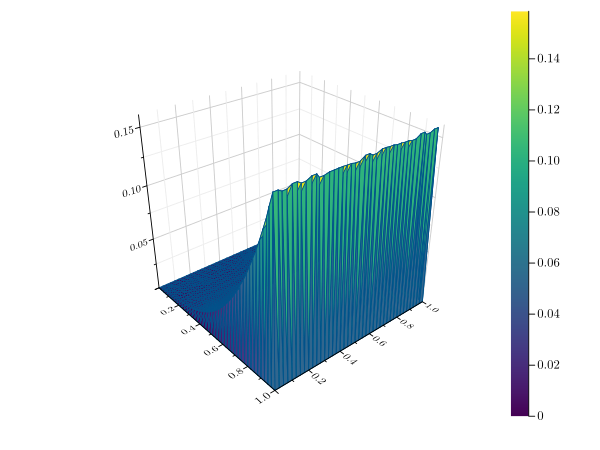

In [22]:
u_exact = ; # I don't know how to get this expression yet
u_exact[bnd_node_ids] .= 0;
err = maximum(abs.(u - u_exact));
GR.trisurf(xnode,ynode,u_exact)